In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop_generator_protein import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.trrosetta_single_model import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

def one_hot_encode_msa(msa, ns=21) :
    
    one_hot = np.zeros((a3m.shape[0], a3m.shape[1], ns))
    for i in range(a3m.shape[0]) :
        for j in range(a3m.shape[1]) :
            one_hot[i, j, int(msa[i, j])] = 1.
    
    return one_hot

import string

def parse_a3m(filename):
    seqs = []
    table = str.maketrans(dict.fromkeys(string.ascii_lowercase))

    # read file line by line
    for line in open(filename,"r"):
        # skip labels
        if line[0] != '>':
            # remove lowercase letters and right whitespaces
            seqs.append(line.rstrip().translate(table))

    # convert letters into numbers
    alphabet = np.array(list("ARNDCQEGHILKMFPSTWYV-"), dtype='|S1').view(np.uint8)
    msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)
    for i in range(alphabet.shape[0]):
        msa[msa == alphabet[i]] = i

    # treat all unknown characters as gaps
    msa[msa > 20] = 20

    return msa


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_kl_loss(target_p_dist, target_p_theta, target_p_phi, target_p_omega) :
    
    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        t_dist = K.clip(K.constant(target_p_dist), K.epsilon(), 1. - K.epsilon())
        t_theta = K.clip(K.constant(target_p_theta), K.epsilon(), 1. - K.epsilon())
        t_phi = K.clip(K.constant(target_p_phi), K.epsilon(), 1. - K.epsilon())
        t_omega = K.clip(K.constant(target_p_omega), K.epsilon(), 1. - K.epsilon())
        
        kl_dist = K.mean(K.sum(t_dist * K.log(t_dist / p_dist), axis=-1), axis=(-1, -2))
        kl_theta = K.mean(K.sum(t_theta * K.log(t_theta / p_theta), axis=-1), axis=(-1, -2))
        kl_phi = K.mean(K.sum(t_phi * K.log(t_phi / p_phi), axis=-1), axis=(-1, -2))
        kl_omega = K.mean(K.sum(t_omega * K.log(t_omega / p_omega), axis=-1), axis=(-1, -2))
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        t_dist = K.clip(K.constant(target_p_dist), K.epsilon(), 1. - K.epsilon())
        t_theta = K.clip(K.constant(target_p_theta), K.epsilon(), 1. - K.epsilon())
        t_phi = K.clip(K.constant(target_p_phi), K.epsilon(), 1. - K.epsilon())
        t_omega = K.clip(K.constant(target_p_omega), K.epsilon(), 1. - K.epsilon())
        
        kl_dist = K.mean(K.sum(t_dist * K.log(t_dist / p_dist), axis=-1), axis=(-1, -2))
        kl_theta = K.mean(K.sum(t_theta * K.log(t_theta / p_theta), axis=-1), axis=(-1, -2))
        kl_phi = K.mean(K.sum(t_phi * K.log(t_phi / p_phi), axis=-1), axis=(-1, -2))
        kl_omega = K.mean(K.sum(t_omega * K.log(t_omega / p_omega), axis=-1), axis=(-1, -2))
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)

#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(loss_funcs, val_loss_funcs, transform_funcs, msa_one_hots, seq_length=100, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(loss_funcs)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        transform_func = transform_funcs[obj_ix]
        msa_one_hot = msa_one_hots[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_valid_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='max', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        #measure_func = lambda pred_outs: np.mean(np.expand_dims(pred_outs[1], axis=0) if len(pred_outs[1].shape) <= 2 else pred_outs[1], axis=0)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        #valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=600, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            #valid_monitor,
            train_history,
            valid_history
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        
        seqprop_predictors.append(seqprop_predictor)
        #valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)

    return seqprop_predictors, train_histories, valid_histories


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../../../trRosetta/network/model2019_07')
model_name = 'model.xaa.h5'
model_path = os.path.join(save_dir, model_name)


In [4]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


In [5]:
msa_file = "../../../trRosetta/example/TR005257.a3m"

a3m = parse_a3m(msa_file)

msa_one_hot = np.expand_dims(one_hot_encode_msa(a3m), axis=0)

print(msa_one_hot.shape)

npz_file = "../../../trRosetta/example/TR005257_xaa.npz"

npz_data = np.load(npz_file)

t_pd, t_pt, t_pp, t_po = npz_data['dist'], npz_data['omega'], npz_data['theta'], npz_data['phi']

print(t_pd.shape)


(1, 124, 72, 21)
(1, 72, 72, 37)


In [6]:
#Optimize max isoform proportions for the 'Alien1' (aka 'Simple') library

rand_seed = 1177#14755

#Run SeqProp Optimization

K.clear_session()

set_seed(rand_seed)

print("Running optimization experiment 'trRosetta Target Structure'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Sequence length
seq_length = msa_one_hot.shape[2]
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Either 'pwm' or 'sample'
eval_mode = 'sample'
#Normalize sequence logits
normalize_logits = True
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

losses, val_losses = zip(*[
    get_kl_loss(
        t_pd,
        t_pt,
        t_pp,
        t_po
    )
])

transforms = [
    None
]

seqprop_predictors, train_histories, valid_histories = run_seqprop(losses, val_losses, transforms, [msa_one_hot], seq_length, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

seqprop_predictor, train_history, valid_history = seqprop_predictors[0], train_histories[0], valid_histories[0]


Running optimization experiment 'trRosetta Target Structure'
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 156s 779ms/step - loss: 1.3013


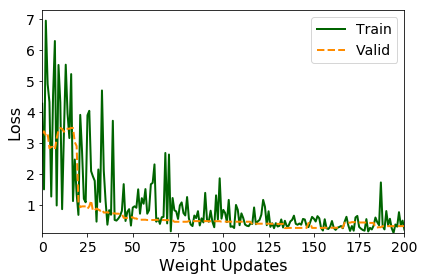

In [7]:
#Store statistics for optimized sequence

save_figs = False
fig_name = "seqprop_rosetta_TR005257_singlesample_w_instancenorm"

f = plt.figure(figsize=(6, 4))

l1 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(train_history.val_loss_history), color='darkgreen', linewidth=2, linestyle='-', label='Train')
l2 = plt.plot(np.arange(n_epochs * steps_per_epoch + 1), np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

plt.xlabel("Weight Updates", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim(0, n_epochs * steps_per_epoch)
plt.ylim(min(np.min(train_history.val_loss_history), np.min(valid_history.val_loss_history)) * 1.05, max(np.max(train_history.val_loss_history), np.max(valid_history.val_loss_history)) * 1.05)

plt.legend(handles=[l1[0], l2[0]], fontsize=14)
plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_loss.svg')
    plt.savefig(fig_name + '_loss.eps')

plt.show()


In [8]:
def letterAt_protein(letter, x, y, yscale=1, ax=None, color='black', alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    #fp = FontProperties(family="Ubuntu", weight="bold")
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    
    globscale = 1.35
    LETTERS = {"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
               "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
               "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
               "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
               
               "L" : TextPath((-0.35, 0), "L", size=1, prop=fp),
               "M" : TextPath((-0.35, 0), "M", size=1, prop=fp),
               "F" : TextPath((-0.35, 0), "F", size=1, prop=fp),
               "W" : TextPath((-0.35, 0), "W", size=1, prop=fp),
               "K" : TextPath((-0.35, 0), "K", size=1, prop=fp),
               "Q" : TextPath((-0.35, 0), "Q", size=1, prop=fp),
               "E" : TextPath((-0.35, 0), "E", size=1, prop=fp),
               "S" : TextPath((-0.35, 0), "S", size=1, prop=fp),
               "P" : TextPath((-0.35, 0), "P", size=1, prop=fp),
               "V" : TextPath((-0.35, 0), "V", size=1, prop=fp),
               "I" : TextPath((-0.35, 0), "I", size=1, prop=fp),
               "Y" : TextPath((-0.35, 0), "Y", size=1, prop=fp),
               "H" : TextPath((-0.35, 0), "H", size=1, prop=fp),
               "R" : TextPath((-0.35, 0), "R", size=1, prop=fp),
               "N" : TextPath((-0.35, 0), "N", size=1, prop=fp),
               "D" : TextPath((-0.35, 0), "D", size=1, prop=fp),
               "U" : TextPath((-0.35, 0), "U", size=1, prop=fp),
               "!" : TextPath((-0.35, 0), "!", size=1, prop=fp),
               
               "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
               "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
               "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
               "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
               ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}

    
    if letter in LETTERS :
        text = LETTERS[letter]
    else :
        text = TextPath((-0.35, 0), letter, size=1, prop=fp)
    
    chosen_color = color
    
    if chosen_color is None :
        chosen_color = 'black'
        if letter in ['A', 'I', 'L', 'M', 'F', 'W', 'V'] : #Hydrophobic
            chosen_color = 'blue'
        elif letter in ['K' ,'R'] : #Positive charge
            chosen_color = 'red'
        elif letter in ['E', 'D'] : #Negative charge
            chosen_color = 'magenta'
        elif letter in ['N', 'Q', 'S', 'T'] : #Polar
            chosen_color = 'green'
        elif letter in ['C'] : #Cysteines
            chosen_color = 'pink'
        elif letter in ['G'] : #Glycines
            chosen_color = 'orange'
        elif letter in ['P'] : #Prolines
            chosen_color = 'yellow'
        elif letter in ['H', 'Y'] : #Aromatic
            chosen_color = 'cyan'

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_protein_logo(inv_residue_map, pwm, meas_str, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(inv_residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\n' + meas_str + ' = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(inv_residue_map)) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = inv_residue_map[i]

            color = None
            if sequence_template[j] != '$' :
                color = 'black'

            if ii == 0 :
                letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(inv_residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()

In [9]:

_, opt_pwm, _, _, _, _, _ = seqprop_predictor.predict(x=None, steps=1)

final_kl_loss = valid_history.val_loss_history[-1]


In [10]:

alphabet_order = "ARNDCQEGHILKMFPSTWYV"#"-"
inv_residue_map = {
    map_key : map_val for map_key, map_val in enumerate(alphabet_order)
}


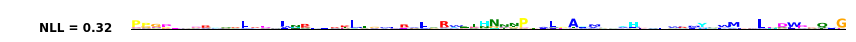

>seqprop_sequence_0
PPGDDQDRYQRLREQINRIFRKITGTFRALSRWSTHNNNPPALPAYMPLYHKLFWRMYQWMCKIEDWDKQVG


In [11]:
#Visualize PWM and get consensus sequence

plot_protein_logo(inv_residue_map, opt_pwm[0, :, :, 0], "NLL", round(final_kl_loss, 2), sequence_template='$' * opt_pwm.shape[1], figsize=(12, 0.65), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=opt_pwm.shape[1])

print(">seqprop_sequence_0")

seq = ""
for j in range(opt_pwm.shape[1]) :
    decoded_residue = inv_residue_map[int(np.argmax(opt_pwm[0, j, :, 0]))]
    seq += decoded_residue

print(seq)


In [20]:

'''
Generated sequence:
PPGDDQDRYQRLREQINRIFRKITGTFRALSRWSTHNNNPPALPAYMPLYHKLFWRMYQWMCKIEDWDKQVG
https://yanglab.nankai.edu.cn/trRosetta/output/TR006700/

True sequence:
SEKELLEELLRLLEELNRINEELVELNRRLLELLRRGADREEILELSRELLELSRELLELSEELLKLVEEARK
https://yanglab.nankai.edu.cn/trRosetta/output/TR005257/

'''


'\nGenerated sequence:\n\n\n\nTrue sequence:\nSEKELLEELLRLLEELNRINEELVELNRRLLELLRRGADREEILELSRELLELSRELLELSEELLKLVEEARK\nhttps://yanglab.nankai.edu.cn/trRosetta/output/TR005257/\n\n'

In [12]:
from definitions.trrosetta_single_model import reweight, msa2pssm, fast_dca, InstanceNormalization

ckpt = "../../../trRosetta/network/model2019_07/model.xaa"

saved_predictor = load_model(ckpt + ".h5", custom_objects = {
    'InstanceNormalization' : InstanceNormalization,
    'reweight' : reweight,
    'wmin' : 0.8,
    'msa2pssm' : msa2pssm,
    'tf' : tf,
    'fast_dca' : fast_dca
})


In [ ]:


one_hot = np.zeros((1, opt_pwm.shape[1], opt_pwm.shape[2]))
for j in range(opt_pwm.shape[1]) :
    max_j = int(np.argmax(opt_pwm[0, j, :, 0]))
    one_hot[0, j, max_j] = 1.

'''
alphabet_order = "ARNDCQEGHILKMFPSTWYV"#"-"
residue_map = {
    map_val : map_key for map_key, map_val in enumerate(alphabet_order)
}

gen_seq = ''

one_hot = np.zeros((1, len(gen_seq), len(residue_map)))
for j in range(len(gen_seq)) :
    one_hot[0, j, residue_map[gen_seq[j]]] = 1.
'''


In [14]:

pd, pt, pp, po = saved_predictor.predict(x=[one_hot, msa_one_hot], batch_size=1)


distance


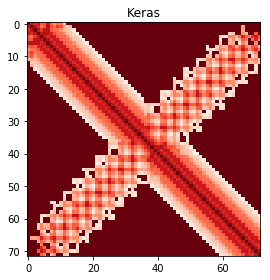

theta


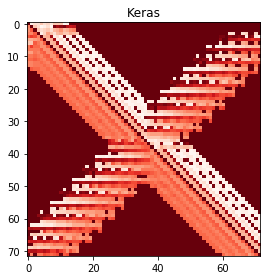

phi


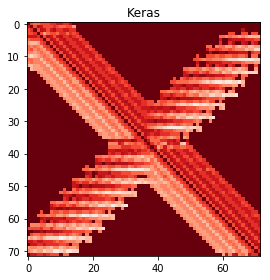

omega


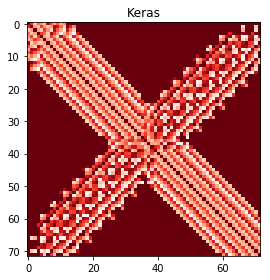

In [15]:

p_list = [
    [pd, 'distance'],
    [pt, 'theta'],
    [pp, 'phi'],
    [po, 'omega']
]

for p_keras, p_name in p_list :

    print(p_name)
    
    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    f = plt.figure(figsize=(4, 4))

    plt.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    plt.title("Keras")

    plt.tight_layout()
    plt.show()
